In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from utils.session_analysis import load_session_data, analyze_single_session, analyze_all_sessions
from utils.statistical_testing import categorise_neurons
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace as Bunch

In [2]:
subject_id = 'EB036'
date = '2024-03-20'

In [3]:
metadata, behavior, spike_counts = load_session_data(subject_id, date)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt






In [412]:
def plot_locomotion_detection(behavior,metadata, running_arena, running_wheel, w_start=0, w_end=200, 
                             onset_threshold=2, offset_threshold=2):
  
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    time = np.arange(w_start, w_end) 
    
    # Arena panel
    ax1.plot(time, behavior.speed_arena[w_start:w_end], 'k-', linewidth=0.8, alpha=0.8)
    
    # Original context mask (light green background)
    ax1.fill_between(time, 0, 30, where=behavior.mask_arena[w_start:w_end],
                     color='#195A2C', alpha=0.2, label='In arena')
    
    # New locomotion mask (dark green bars at bottom)
    locomotion_height = np.ones_like(time) * 0.5
    ax1.fill_between(time, 0, locomotion_height, 
                     where=running_arena[w_start:w_end],
                     color='#0B3D0B', alpha=0.8, label='Locomotion bout')
    
    # Threshold lines
    ax1.axhline(onset_threshold, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.axhline(offset_threshold, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    
    ax1.set_ylabel('Arena speed (cm/s)')
    ax1.set_ylim(0, max(15, behavior.speed_arena[w_start:w_end].max() * 1.1))
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Wheel panel
    ax2.plot(time, behavior.speed_wheel[w_start:w_end], 'k-', linewidth=0.8, alpha=0.8)
    
    # Original context mask (light purple background)
    ax2.fill_between(time, 0, 30, where=behavior.mask_wheel[w_start:w_end],
                     color='#7D0C81', alpha=0.2, label='On wheel')
    
    # New locomotion mask (dark purple bars at bottom)
    ax2.fill_between(time, 0, locomotion_height, 
                     where=running_wheel[w_start:w_end],
                     color='#3D053F', alpha=0.8, label='Locomotion bout')
    
    # Threshold lines
    ax2.axhline(onset_threshold, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax2.axhline(offset_threshold, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    
    ax2.set_ylabel('Wheel speed (cm/s)')
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylim(0, max(15, behavior.speed_wheel[w_start:w_end].max() * 1.1))
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
   
    
    # Clean up
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

In [413]:
w_start=0
w_end=2000

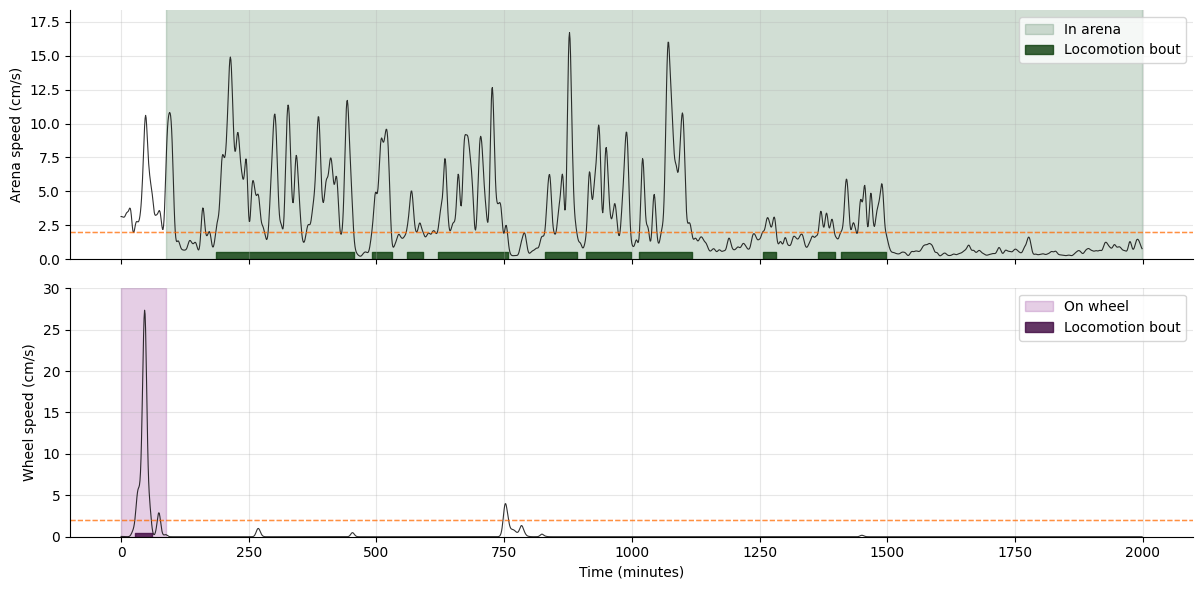

In [414]:
plot_locomotion_detection(behavior, metadata, running_arena, running_wheel, w_start, w_end)

In [166]:
bout_wheel_masks, bout_wheel = get_locomotion_bouts(behavior.speed_wheel, behavior.mask_wheel)

In [ ]:
def compute_speed_tuning(spike_counts, speed, mask, n_bins=10, dt=0.1):
    # Only use data from this context
    context_speed = speed[mask]
    context_spikes = spike_counts[:, mask]
    
    # Create bins
    speed_bins = np.linspace(0, np.nanmax(context_speed), n_bins + 1)
    bin_centers = 0.5 * (speed_bins[:-1] + speed_bins[1:])
    
    # Initialize output
    n_neurons = spike_counts.shape[0]
    firing_rates = np.zeros((n_neurons, n_bins))
    
    # Digitize speeds
    speed_indices = np.digitize(context_speed, speed_bins) - 1
    
    # Calculate firing rates for each bin
    for i in range(n_bins):
        idx = speed_indices == i
        occupancy = np.sum(idx) * dt
        
        if occupancy > 1.0:  # Minimum 1 second occupancy
            spikes_in_bin = context_spikes[:, idx].sum(axis=1)
            firing_rates[:, i] = spikes_in_bin / occupancy
        else:
            firing_rates[:, i] = np.nan
    
    return bin_centers, firing_rates


In [10]:
oa_bins, oa_tuning = compute_speed_tuning(spike_counts, behavior.speed_arena, 
                                          behavior.mask_arena)
wh_bins, wh_tuning = compute_speed_tuning(spike_counts, behavior.speed_wheel, 
                                          behavior.mask_wheel)

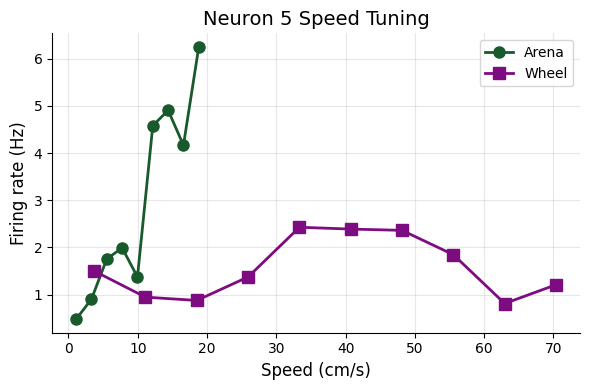

In [19]:
# Pick a neuron to plot
neuron_idx = 5  # Change this to whichever neuron you want

# Create the plot
plt.figure(figsize=(6, 4))

# Plot arena tuning curve
plt.plot(oa_bins, oa_tuning[neuron_idx, :], 'o-', color='#195A2C', 
         label='Arena', linewidth=2, markersize=8)

# Plot wheel tuning curve  
plt.plot(wh_bins, wh_tuning[neuron_idx, :], 's-', color='#7D0C81',
         label='Wheel', linewidth=2, markersize=8)

# Labels and formatting
plt.xlabel('Speed (cm/s)', fontsize=12)
plt.ylabel('Firing rate (Hz)', fontsize=12)
plt.title(f'Neuron {neuron_idx} Speed Tuning', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()